# Chapter 4: Training a GPT Model

<div class="alert alert-block alert-success">
In the previous chapters, we successfully designed and built every architectural component of a GPT model from scratch. We now have a complete, functional `GPTModel` class ready to be used.

However, the model currently has randomly initialized weights and knows nothing about language. In this chapter, we will take the crucial next step: **training the model**. We will feed it a text corpus, calculate its performance using a loss function, and iteratively update its weights to teach it to generate coherent text.
</div>

## 4.1 Import and Setup

<div class="alert alert-block alert-success">
We'll begin by importing the necessary libraries and the `GPTModel` we finalized in the last chapter.
</div>

In [39]:
# Standard library and third-party imports
import sys
import os
import torch
import torch.nn as nn
import tiktoken

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# --- Add Project Root to Python Path ---

# Get the directory of the current notebook
current_notebook_dir = os.getcwd()

# Go up one level to the project's root directory
project_root = os.path.abspath(os.path.join(current_notebook_dir, '..'))

# Add the project root to the Python path if it's not already there
if project_root not in sys.path:
    sys.path.append(project_root)

# --- Imports from your `src` package ---
from src.data_loader import create_dataloader
from src.utils import load_data
from src.model import GPTModel

# We will use the same configuration dictionary
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "dropout_rate": 0.1,
    "qkv_bias": False
}

## 4.2 Generating Text with the Untrained Model

<div class="alert alert-block alert-success">
    
Before we train the model, let's see what it produces with its random, untrained weights. To do this, we need a function that can perform an **autoregressive** generation loop. This process involves feeding the model an initial context, predicting the next token, adding that token back to the context, and repeating the process.
</div>

In [2]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context

    for _ in range(max_new_tokens):
        # Crop current context if exceeds the supported context size
        idx_cond = idx[:, -context_size:]

        # Get the predictions from the model
        with torch.no_grad():
            logits = model(idx_cond) ### batch, n_tokens, vocab_size

         # Focus only on the prediction for the very last token in the sequence
        logits = logits[:, -1, :]

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)

        # Get the token ID with the highest probability (greedy decoding)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)

        # Append the new token ID to therunning sequence
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

<div class="alert alert-block alert-success">
    
The `generate_text_simple` function implements **greedy decoding**. In this autoregressive process, the model repeatedly predicts the single most likely next token, appends it to the sequence, and feeds the new sequence back into the model.

</div>

<div class="alert alert-block alert-info">
    
  <b>A Note on `softmax` and `argmax`</b><br>
  
  In our function, we include a `softmax` step to convert the model's output scores (logits) into probabilities before finding the most likely token with `argmax`.

  However, since `softmax` doesn't change the order of the scores, applying `argmax` directly to the `logits` would produce the exact same result. We include the step here to clearly illustrate the full process of generating probabilities, but it is technically redundant for greedy decoding.
</div>

<div class="alert alert-block alert-success">
Later in this chapter, when we will implement the GPT training code, we will also introduce additional sampling techniques where we modify the softmax outputs such that the model doesn't always select the most likely token, which introduces variability and creativity in the generated text.
</div>

<div class="alert alert-block alert-success">
Now, let's test our `generate_text_simple` function. We'll provide it with the starting context "Hello, I am" by first encoding the string into a batch of token IDs.
</div>

In [3]:
# Prepare the input
start_context = "Hello, I am"
tokenizer = tiktoken.get_encoding("gpt2")
encoded = tokenizer.encode(start_context)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded:", encoded)
print("Encoded tensor shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
Encoded tensor shape: torch.Size([1, 4])


<div class="alert alert-block alert-success">
Next, we'll set the model to evaluation mode with `model.eval()`. This disables random components like dropout that are only used during training. We can then call our function to generate new tokens from the starting context.
</div>

In [4]:
# --- Instantiate the Model ---
torch.manual_seed(100)
model = GPTModel(GPT_CONFIG_124M)
model.eval() # Set to evaluation mode

print("Model instantiated successfully.")

Model instantiated successfully.


<div class="alert alert-block alert-success">
Let's generate text using our `generate_text_simple` function.
</div>

In [5]:
# Generate text
output_ids = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", output_ids)
print("Output length:", len(output_ids[0]))

Output: tensor([[15496,    11,   314,   716,  1908, 41574, 14356, 11426, 42884, 32296]])
Output length: 10


<div class="alert alert-block alert-success">
    
Finally, we use the tokenizer's `.decode()` method to convert the output token IDs back into a readable string.
</div>

In [6]:
# Decode the output
decoded_text = tokenizer.decode(output_ids.squeeze(0).tolist())
print(f"\nDecoded text: '{decoded_text}'")


Decoded text: 'Hello, I am sent agitated AW telephone Tomas shroud'


<div class="alert alert-block alert-warning">
    
  <b>Why is the output gibberish?</b><br>
  
  As we can see, the generated text is incoherent. This is the correct and expected result at this stage.

  The reason is that our model is completely **untrained**. Its weights are still the random values they were initialized with. It has not yet learned any patterns of the English language. This demonstration perfectly illustrates *why* we need to train the model. In the next sections, we will prepare a dataset and implement a training loop to do just that.
</div>

## 4.3 Evaluating Generative Text Models

<div class="alert alert-block alert-success">

In the previous section, we saw that our untrained model produces incoherent gibberish. While we can see this qualitatively, we need a quantitative way to measure the model's performance. How do we capture "good text" versus "bad text" in a number that we can track and optimize?

The answer is to use a **loss function**. For language models that predict next-token probabilities, the standard metric is **cross-entropy loss**. It measures how "surprised" the model is by the true next token; a lower loss means the model's predictions are closer to reality. A related, more interpretable metric is **perplexity**.
</div>

<div class="alert alert-block alert-success">

Before we can calculate these metrics, we need to prepare our workspace. This involves two main setup steps:

1.  **Initialize the Model:** We will instantiate a `GPTModel` using our configuration with a `context_length` of 256. Using a smaller context size (compared to the original GPT-2's 1024) reduces the computational requirements, making the examples in this chapter accessible on a standard laptop.

2.  **Define Helper Functions:** We will define two convenience functions, `text_to_token_ids` and `token_ids_to_text`. These utilities will make it easier to convert back and forth between text and the model's numerical token IDs throughout our analysis.
</div>

In [7]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "dropout_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(100)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

In [8]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

<div class="alert alert-block alert-success">

With our model initialized and helper functions defined, we can now perform our first end-to-end text generation. We will provide the model with the starting context "Every effort moves you" and use the `generate_text_simple` function to have it autoregressively generate the next 10 tokens.
</div>    

start_context = "Every effort moves yosu"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_contexta2, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

<div class="alert alert-block alert-success">

As we can see above, the model does not produce good text because it has not been trained yet.

**How do we measure or capture what "good text" is, in a numeric form, to track it during training?**

The next subsection introduces metrics to calculate a loss metric for the generated output that we can use to measure the training progress.

The next chapters on finetuning LLMs will also introduce additional ways to neasure model quality.
</div>

## 4.4 Calculating the Text Generation Loss: Cross-Entropy and Perplexity

<div class="alert alert-block alert-success">

Suppose we have an inputs tensor containing the token IDs for 2 training example (rows).

Corresponding to the inputs, the targets contain the desired token IDs that we want the model to generate.

Notice that the targets are the inputs shifted by 1 position, as we explained in *Chapter 1* when we implemented the data loader.
</div>

In [9]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

<div class="alert alert-block alert-success">
Feeding the inputs to the model, we obtain the logits vector for the 2 input examples that consist of 3 tokens each.

Each of the tokens is a 50,257-dimensional vector corresponding to the size of the vocabulary.

Applying the softmax function, we can turn the logits into a tensor of the same dimension containing probability scores.
</div>

In [10]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


<div class="alert alert-block alert-success">

As discussed in the previous section, we can apply the argmax function to convert theprobability scores into predicted token IDs.

The softmax function above produced a 50,257-dimensional vector for each token; the argmax function returns the position of the highest probability score in this vector, which is the predicted token ID for the given token.

Since we have 2 input batches with 3 tokens each, we obtain 2 by 3 predicted token IDs.
</div>

In [11]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[24926],
         [49334],
         [45732]],

        [[ 3401],
         [13257],
         [46567]]])


<div class="alert alert-block alert-success">

If we decode these tokens, we find that these are quite different from the tokens we want the model to predict, namely the target tokens.

That's because the model wasn't trained yet.

To train the model, we need to know how far it is away from the correct predictions (targets).
</div>

In [12]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  huhbrainer Harding


### 4.4.1 Cross-Entropy Loss

<div class="alert alert-block alert-success">
The token probabilities corresponding to the target indices are as follows:
</div>

In [13]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([9.0643e-06, 6.8038e-06, 6.5535e-05])
Text 2: tensor([1.0236e-04, 2.3294e-05, 1.6344e-05])


<div class="alert alert-block alert-success">

We want to maximize all these values, bringing them close to a probability of 1.

In mathematical optimization, it is easier to maximize the logarithm of the probability score than the probability score itself.
</div>

In [14]:
# Compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([-11.6112, -11.8980,  -9.6329,  -9.1870, -10.6673, -11.0216])


<div class="alert alert-block alert-success">

Next, we compute the average log probability:
</div>

In [15]:
# Calculate the average probabililty for each token
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.6697)


<div class="alert alert-block alert-success">

The goal is to make this average log probability as large as possible by optimizing the model weights.

Due to the log, the largest possible value is 0, and we are currently far away from 0.

In deep learning, instead of maximizing the average log-probability, it's a standard convention to minimize the negative average log-probability value; in our case, instead of maximizing -10.6697 so that it approaches 0, we would maximize 10.6697 so that it approaches 0.

The negative value of -10.6697, i.e., 10.6697, is also called **cross-entropy loss** in deep learning.
</div>

In [16]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.6697)


### 4.4.2 Cross-Entropy Loss Using PyTorch's Optimized Function



<div class="alert alert-block alert-success">

Thankfully, we don't have to do all that math manually. PyTorch provides a highly optimized `cross_entropy` function that performs the softmax and log-probability calculations for us.

Before we can use it, we need to reshape our `logits` and `targets` tensors. The function expects the `logits` to have the shape `(N, C)` where `C` is the number of classes (our `vocab_size`), so we will flatten the batch and token dimensions together.
</div>

In [17]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


<div class="alert alert-block alert-success">

For the **cross_entropy** function in PyTorch, we want to flatten these tensors by combining them over the batch dimension:
</div>

In [18]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits shape:", logits_flat.shape)
print("Flattened targets shape:", targets_flat.shape)

Flattened logits shape: torch.Size([6, 50257])
Flattened targets shape: torch.Size([6])


<div class="alert alert-block alert-success">

Note that the targets are the token IDs, which also represent the index positions in the logits tensor that we want to maximize.

The cross_entropy function in PyTorch will automatically take care of applying the softmax and log-probability computation internally over those token indices in the logits that are to be maximized.
</div>

In [19]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.6697)


### 4.4.3 Perplexity

<div class="alert alert-block alert-success">
    <b>From Loss to an Interpretable Metric: Perplexity</b><br>
    A concept directly related to cross-entropy is <b>perplexity</b>. It is simply the exponential of the cross-entropy loss:
    <br><br>
    $$ \text{Perplexity} = e^{\text{Cross-Entropy Loss}} $$
    <br>
</div>

In [20]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(43031.3984)


<div class="alert alert-block alert-success">

The **perplexity** is often considered more interpretable because it can be understood as the effective vocabulary size that the model is uncertain about at each step (in the example above, that would be 43,031 words or tokens).

In other words, perplexity provides a measure of how well the probability distribution predicted by the model matches the actual distribution of the words in the dataset.

Similar to the loss, a lower perplexity indicates that the model predictions are closer to the actual distribution.
</div>

## 4.5 Setting Up the Dataset and Loss Functions

<div class="alert alert-block alert-success">

For this project, we will train our LLM on a relatively small dataset: a single short story. There are several practical reasons for this choice:

<ul>
    <li><b>Accessibility:</b> We can run all the code examples in a few minutes on a standard laptop without needing a powerful GPU.</li>
    <li><b>Speed:</b> The training process finishes quickly, whihc is ideal for experimentation.</li>
    <li><b>Licensing:</b> The text is in the public domain, so it can be included in this repository without any usage rights issues.</li>
</ul>

<div class="alert alert-block alert-info">
    <b>A Note on Real-World Scale</b><br>
    While our dataset has about 5,000 tokens, it's important to understand the scale of real-world models. For example, training Llama 2 (7B) required <b>2 trillion tokens</b> and approximately <b>$700,000</b> in cloud computing costs.
</div>

With our small dataset, the next step is to divide it into a training set (for the model to learn from) and a validation set (to check the model's performance on unseen data).
</div>

### 4.5.1 Preparing the DataLoaders

<div class="alert alert-block alert-success">

We will use the same text corpus ("The Verdict") and the same datga loader from our previous work. The process involves:

1. Loading the text file.
2. Splitting it into a 90% training set and 10% validation set.
3. Using our `GPTDatasetV1` and `create_dataloader` class and function to create data loaders that will feed the data to our model in batches.

</div>

In [21]:
# 1. Load the data
file_path = "../data/the-verdict.txt"
url = "https://raw.githubusercontent.com/JotaCe7/llm-text-preprocessing/main/data/the-verdict.txt"
text_data = load_data(file_path=file_path, url=url)

total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("\nCharacters:", total_characters)
print("Tokens:", total_tokens)

File '../data/the-verdict.txt' already exists. Loading fomr disk...
Load complete.

Characters: 20479
Tokens: 5145


In [22]:
# 2. Split the data into training and validation sets
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

print(f"Characters in training set: {len(train_data):,}")
print(f"Characters in validation set: {len(val_data):,}")

Characters in training set: 18,431
Characters in validation set: 2,048


In [23]:
# 3. Create the data loaders
torch.manual_seed(100)

train_loader = create_dataloader(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    shuffle=True,
    drop_last=True
)

val_loader = create_dataloader(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    shuffle=False,
    drop_last=False
)

# Optional check to validate datakiader were created correctly
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)
print(f"{len(train_loader)} tarining batches")
print(f"{len(val_loader)} validation batches")

train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("\nTraining tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])
9 tarining batches
1 validation batches

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


In [24]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

### 4.5.2 Defining the Loss Function

<div class="alert alert-block alert-success">

Next, we need functions to calculate the loss. We will use **cross-entropy loss**, which is the standard for language models. The `calc_loss_batch` function computes the loss for a single batch, and `calc_loss_loader` will average the loss over multiple batches from a data loader.
</div>

In [25]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i <num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

<div class="alert alert-block alert-success">

Now, let's calculate the initial loss on our training and validation sets before any training has occurred. This gives us a baseline to measure our progress against
</div>

In [26]:
# Set the devive
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model.to(device)

# Calculte initial losses
with torch.no_grad(): # Disable gradient tracking for this calculation
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print(f"Initial Training loss: {train_loss:.3f}")
print(f"Initial Validation loss: {val_loss:.3f}")

Initial Training loss: 10.980
Initial Validation loss: 10.959


## 4.6 Implementing and Running the Training Loop

<div class="alert alert-block alert-success">

With our data loaders and loss functions ready, we have all the preerquisites for training. We will now define the main thaining function that iterate over the data, computes the loss, and updates the model weights's.
</div>

### 4.6.1 Defining the Training and Evaluation Functions

<div class="alert alert-block alert-success">

We need three helper functions for our training process:

* **`train_model_simple:`** The main function that contains the training loop over multiple epochs.
* **`evaluate_model:`** A function to periodically calculate the loss on the training and validation sets to monitor performance.
* **`generate_and_print_sample:`** A function to generate sample text after each epoch so we can qualitatively see how the model is improving.
</div>

In [27]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train
    return train_loss, val_loss

def generate_and_print_sample(model, tokenizer, device, start_context, max_new_tokens=50):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=max_new_tokens,
            context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep. {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:3f}, Val loss {val_loss:3f}")

                # Print a sample text after each epoch
                generate_and_print_sample(
                    model, tokenizer, device, start_context)

    return train_losses, val_losses, track_tokens_seen
            

### 4.6.2 Kicking Off the Trainig Run

<div class="alert alert-block alert-success">

With all our helper function defined, we are finally ready to train our GPT model! We will instantiate a new model and a and an AddamW optimizer, then call our main training function for 10 epochs.
</div>

In [31]:
import time

start_time = time.time()

torch.manual_seed(100)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

end_time = time.time()

execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:2f} minutes.")

Ep. 1 (Step 000000): Train loss 9.912392, Val loss 10.146250
Every effort moves you the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the, the the the the the the the the the the the
Ep. 1 (Step 000005): Train loss 8.021554, Val loss 8.372361
Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ep. 2 (Step 000010): Train loss 6.659008, Val loss 7.080389
Every effort moves you.                                                 
Ep. 2 (Step 000015): Train loss 6.045608, Val loss 6.617142
Every effort moves you, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the
Ep. 3 (Step 000020): Train loss 5.465610, Val loss 6.449451
Every effort moves you, and, and", and, and, and, and I had the, and, and I of the, and, and, and, and, and, and, and, and, and, and, and, and, and of
Ep. 3 (Step 000025): Train loss 5.

<div class="alert alert-block alert-success">

As we can see, based on the results printed during the training, the training loss improves drastically, starting with a value of 9.912392 and converging to 0.895781.

The language sikills of the model have improvded quite a lot too. In the beginning, the model is only able to append commas to the start context ("Every effort moves you,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,") or repeat the worl "the"/"and".

At the end of the training, it can generate grammatically correct text.
</div>

<div class="alert alert-block alert-success">

Similar to the training set loss, we can see that the validation set loss starts high (10.146250) and decreases during the training.

However, it never becomes as small as the training set loss and remains at 6.393708 after the 10th epoch.
</div>

<div class="alert alert-block alert-info">
    
  <b>A Note on the AdamW Optimizer</b><br>
  
  The <b>AdamW optimizer</b> is a modern and powerful algorithm that has become a standard and highly recommended choice for training large language models like GPT. It enhances the popular Adam optimizer with an improved implementation of weight decay.

  <ul>
    <li><b>Adaptive Learning Rates:</b> Like Adam, it maintains a unique, adaptive learning rate for every single weight in the model. This means it can learn faster on some parameters and more cautiously on others.</li>
    <li><b>Momentum:</b> It uses momentum, which is like a memory of past gradients, to help it move more consistently in the right direction during optimization.</li>
    <li><b>Improved Weight Decay ("W"):</b> The 'W' in AdamW stands for Weight Decay. It fixes a flaw in the original Adam's implementation of weight decay (a regularization technique that helps prevent overfitting). This decoupled approach often leads to better model performance and generalization.</li>
  </ul>
  
  Because of its robustness and effectiveness, AdamW is now the default optimizer for most transformer-based projects.
</div>

### 4.6.3 Analyzing the Training Results

<div class="alert alert-block alert-success">

After training is complete, the best way to understand how the model learned is to plot the training and validation loss curves over time. A decreasing loss indicates that the model is learning the patterns in the text.
</div>

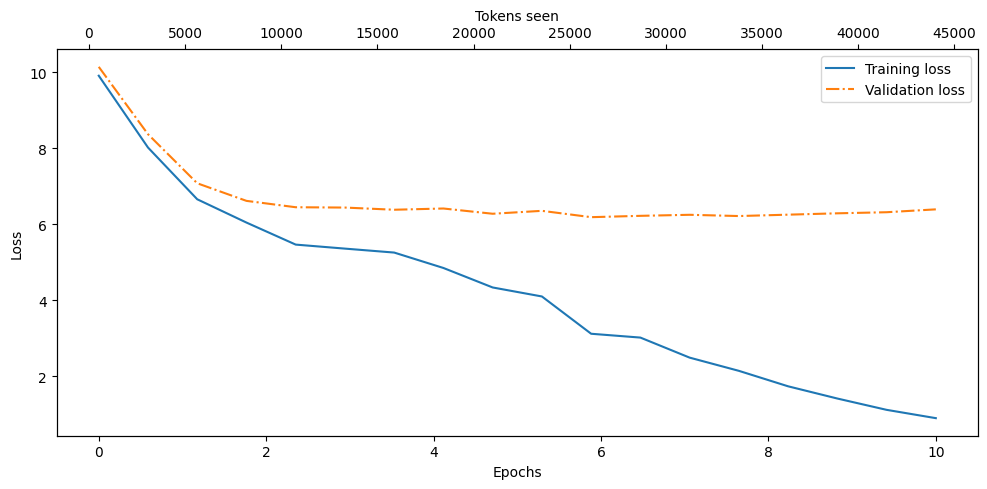

In [56]:
def plot_losses(epochs_seen, tokens_seen,train_losses, val_losses):
    """Plots the training and validation loss curves."""
    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot training and validation losses against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True)) # only show integer labels on bottom x-axis

    # Creeate a second x-axis for tokens seen
    ax2 = ax1.twiny() # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0) # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")
    ax2.xaxis.set_major_locator(MaxNLocator(integer=True)) # only show integer labels on upper x-axis

    fig.tight_layout() # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)  
    

<div class="alert alert-block alert-info">
    
  <b>Analysis: Interpreting the Loss Curves and Overfitting</b><br>
    
  The plot clearly shows both the training and validation losses decreasing sharply, which means our model is successfully learning from the data.
  
  However, notice the growing gap between the training loss and the validation loss. When the validation loss is significantly higher than the training loss (or even starts to increase), it's a classic sign of <b>overfitting</b>. The model is beginning to memorize the small training dataset instead of learning general language patterns, which we can confirm by searching for the generated text snippets, such as `"I had again run over from"` in the "The Verdict" text file. This is expected because our dataset is tiny and we are training for several epochs. In a real-world scenario with a massive dataset, we would typically only train for a single epoch.
</div>